# Discrete hedging experiment for a European Call option under the Heston model using the Wilmott $\Delta$

> TODO: Add a description to the experiment

> Under the Heston but we are using the Black-Scholes delta for hedging

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

from jax import vmap, grad
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import gamma_european
from jaxfin.price_engine.fft import fourier_inv_call, delta_call_fourier

from src.experimental.bs_iv import IV_brent
import py_vollib_vectorized

In [3]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [4]:
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.04
mean = 0.0
kappa = 1.0
theta = 0.04
sigma = 0.1
rho = -0.7

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [5]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 100
risk_adv = 2

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

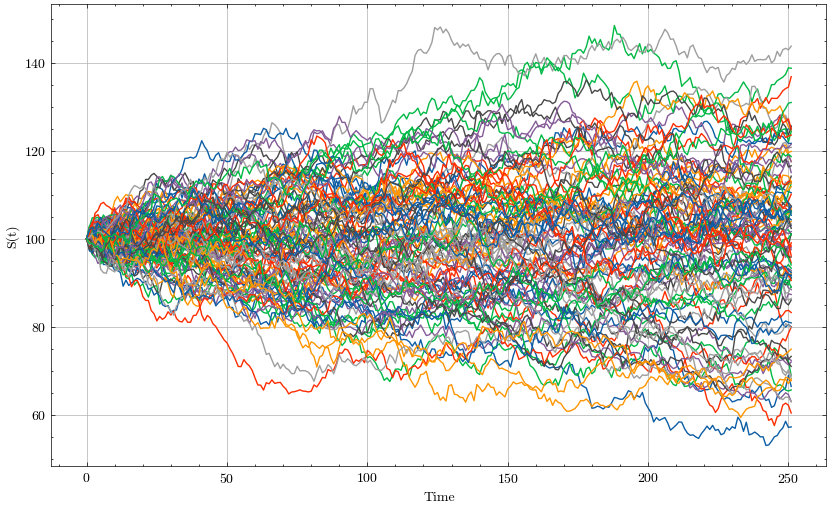

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:, :100])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [7]:
discount_rate = 0.0
r = discount_rate
dividends = 0.0

## Hedging experiment without transaction costs

In [8]:
ticksize = 0.00
K = 100
maturity = 1.0
N = 252
n_sim = 100

v_gamma_european = vmap(gamma_european, in_axes=(0, None, None, None, None))
v_v_gamma_european = vmap(v_gamma_european, in_axes=(None, None, None, 0, None))
v_fourier_delta_call = vmap(delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_delta_call = vmap(v_fourier_delta_call, in_axes=(None, None, None, 0, None, None, None, None, None))
v_fourier_inv_call = vmap(fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_inv_call = vmap(v_fourier_inv_call, in_axes=(None, None, None, 0, None, None, None, None, None))

In [9]:
def heston_vega(s0, K, T, v, mu, theta, sigma, kappa, rho):
    return grad(fourier_inv_call, argnums=3)(s0, K, T, v, mu, theta, sigma, kappa, rho)

_v_heston_vega = vmap(heston_vega, in_axes=(0, None, None, None, None, None, None, None, None))
v_heston_vega = vmap(_v_heston_vega, in_axes=(None, None, None, 0, None, None, None, None, None))

In [10]:
def get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    deltas = [v_v_fourier_delta_call(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    deltas_ = [v_v_fourier_delta_call(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(deltas + deltas_)

def get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    vegas = [v_heston_vega(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    vegas_ = [v_heston_vega(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(vegas + vegas_)

def get_heston_hedging_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    vegas = get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)
    deltas = get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)

    return deltas + (rho * sigma / stock_paths) * vegas


In [11]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [12]:
def rehedge(current_delta, bs_delta, time_to_exp, kappa, s_t, gamma):
    rhs = (1.5 * ((np.exp(-r*time_to_exp) * kappa * s_t * gamma**2) / risk_adv))**(1/3)
    return ~(np.abs(current_delta - bs_delta) > rhs)

def willmot_delta(current_delta, bs_delta, time_to_exp, kappa, s_t, gamma):
    condition =  rehedge(current_delta, bs_delta, time_to_exp, kappa, s_t, gamma)    
    return current_delta.at[:].set(jnp.where(condition, bs_delta[:], current_delta[:]))

In [13]:
def hedge_experiment_loop(stock_paths, v_process, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    dt = maturity / N
    deltas = get_heston_hedging_deltas(stock_paths, var_process, K, maturity, discount_rate, theta, sigma, kappa, rho, N)
    gammas = [v_v_gamma_european(stock_paths[i], K, maturity - i * dt, jnp.sqrt(v_process[i]), discount_rate).diagonal() for i in range(0, N)]
    cs = [v_v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, var_process[i], discount_rate, theta, sigma, kappa, rho).diagonal() for i in range(0, N)]
    b = [cs[0] - deltas[0] * stock_paths[0]]
    vs = [cs[0]]
    previous_delta = deltas[0]
    current_delta = deltas[0]

    for i in range(1, N):
        current_delta = willmot_delta(current_delta, deltas[i], maturity - i * dt, ticksize, stock_paths[i], gammas[i])
        ddelta = current_delta - previous_delta
        transaction_costs = get_transaction_costs(ticksize, ddelta)

        vs.append(previous_delta * stock_paths[i] + b[i - 1])
        
        previous_delta = current_delta

        b.append(vs[i] - current_delta * stock_paths[i] - transaction_costs)
        
    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

    return jnp.mean(hedge_error[-1]), jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]

### Experiments

In [14]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [15]:
def update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

    results['Strike'].append(K)
    results['Sigma'].append(sigma)
    results['Maturity'].append(maturity)
    results['Rebalancing_freq'].append(N)
    results['E_PL_T'].append(mean_hedge_error)
    results['Std_PL_T'].append(std_hedge_error)

    print(f'The mean hedge error is: {mean_hedge_error}')
    print(f'The normalized std of the hedge error is: {std_hedge_error}')

    return results

In [16]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.13269485533237457
The normalized std of the hedge error is: 0.7295669913291931


Weekly rebalancing $n=52$

In [17]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [18]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.8459088802337646
The normalized std of the hedge error is: 0.7787789106369019


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [19]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [20]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.38875991106033325
The normalized std of the hedge error is: 0.1665012538433075


Weekly rebalancing $n=52$

In [21]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [22]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.2687845230102539
The normalized std of the hedge error is: 0.15372513234615326


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [23]:
K = 90
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [24]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.0649646744132042
The normalized std of the hedge error is: 0.36894991993904114


Weekly rebalancing $n=52$

In [25]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [26]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.1064048707485199
The normalized std of the hedge error is: 0.3909316062927246


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [27]:
K = 110
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [28]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -1.0493086576461792
The normalized std of the hedge error is: 1.4974687099456787


Weekly rebalancing $n=52$

In [29]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [30]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.001034545828588307
The normalized std of the hedge error is: 1.2792906761169434


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [31]:
K = 120
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [32]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.3046075105667114
The normalized std of the hedge error is: 2.868499755859375


Weekly rebalancing $n=52$

In [33]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [34]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.29599809646606445
The normalized std of the hedge error is: 2.6842544078826904


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [35]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [36]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 1.1914514303207397
The normalized std of the hedge error is: 0.6136627197265625


Weekly rebalancing $n=104$

In [37]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [38]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -1.102203369140625
The normalized std of the hedge error is: 0.7051026225090027


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [39]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [40]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [41]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [42]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [43]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [44]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [45]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [46]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [47]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,0.13269486,0.729567
1,100,0.1,1.0,52,-0.8459089,0.7787789
2,80,0.1,1.0,252,-0.3887599,0.16650125
3,80,0.1,1.0,52,-0.26878452,0.15372513
4,90,0.1,1.0,252,0.064964674,0.36894992
5,90,0.1,1.0,52,-0.10640487,0.3909316
6,110,0.1,1.0,252,-1.0493087,1.4974687
7,110,0.1,1.0,52,0.0010345458,1.2792907
8,120,0.1,1.0,252,-0.3046075,2.8684998
9,120,0.1,1.0,52,-0.2959981,2.6842544


In [48]:
res_df.to_csv('./results/heston_delta_w_zero.csv')

### Hedging experiments with low transcation costs

### Experiments

In [49]:
ticksize = 0.01
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [50]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [51]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.012717494741082191
The normalized std of the hedge error is: 0.4578598737716675


Weekly rebalancing $n=52$

In [52]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [53]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.2766137421131134
The normalized std of the hedge error is: 0.5269240736961365


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [54]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [55]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.26243969798088074
The normalized std of the hedge error is: 0.03366880863904953


Weekly rebalancing $n=52$

In [56]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [57]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.7130734920501709
The normalized std of the hedge error is: 0.17640197277069092


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [58]:
K = 90
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [59]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.485798716545105
The normalized std of the hedge error is: 0.2259632647037506


Weekly rebalancing $n=52$

In [60]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [61]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.13275083899497986
The normalized std of the hedge error is: 0.30952784419059753


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [62]:
K = 110
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [63]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.22979553043842316
The normalized std of the hedge error is: 0.5599328279495239


Weekly rebalancing $n=52$

In [64]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [65]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.4952983856201172
The normalized std of the hedge error is: 1.274281620979309


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [66]:
K = 120
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [67]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.07146503031253815
The normalized std of the hedge error is: 1.233397364616394


Weekly rebalancing $n=52$

In [68]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [69]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.3628859519958496
The normalized std of the hedge error is: 1.8329740762710571


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [70]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [71]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.029407748952507973
The normalized std of the hedge error is: 0.25389423966407776


Weekly rebalancing $n=104$

In [72]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [73]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.3536931574344635
The normalized std of the hedge error is: 0.6829215884208679


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [74]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [75]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [76]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [77]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [78]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [79]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [80]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [81]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [82]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,0.012717495,0.45785987
1,100,0.1,1.0,52,0.27661374,0.5269241
2,80,0.1,1.0,252,0.2624397,0.03366881
3,80,0.1,1.0,52,-0.7130735,0.17640197
4,90,0.1,1.0,252,-0.48579872,0.22596326
5,90,0.1,1.0,52,0.13275084,0.30952784
6,110,0.1,1.0,252,0.22979553,0.5599328
7,110,0.1,1.0,52,0.4952984,1.2742816
8,120,0.1,1.0,252,-0.07146503,1.2333974
9,120,0.1,1.0,52,0.36288595,1.8329741


In [83]:
res_df.to_csv('./results/heston_delta_w_low.csv')

### Hedging experiments with high transcation costs

### Experiments

In [84]:
ticksize = 0.05
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [85]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [86]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.33466097712516785
The normalized std of the hedge error is: 0.09550502151250839


Weekly rebalancing $n=52$

In [87]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [88]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.44533202052116394
The normalized std of the hedge error is: 0.40203171968460083


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [89]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [90]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.13542777299880981
The normalized std of the hedge error is: 0.02108304388821125


Weekly rebalancing $n=52$

In [91]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [92]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.15161196887493134
The normalized std of the hedge error is: 0.09006945043802261


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [93]:
K = 90
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [94]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.27104684710502625
The normalized std of the hedge error is: 0.05839642137289047


Weekly rebalancing $n=52$

In [95]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [96]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.18502742052078247
The normalized std of the hedge error is: 0.20499448478221893


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [97]:
K = 110
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [98]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.18115821480751038
The normalized std of the hedge error is: 0.23011408746242523


Weekly rebalancing $n=52$

In [99]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [100]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.041117992252111435
The normalized std of the hedge error is: 0.6604811549186707


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [101]:
K = 120
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [102]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.1391940414905548
The normalized std of the hedge error is: 0.3560725450515747


Weekly rebalancing $n=52$

In [103]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [104]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.05237375199794769
The normalized std of the hedge error is: 1.1981806755065918


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [105]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [106]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.0943281427025795
The normalized std of the hedge error is: 0.21092510223388672


Weekly rebalancing $n=104$

In [107]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [108]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.010326442308723927
The normalized std of the hedge error is: 0.3328035771846771


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [109]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [110]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [111]:
N = 26

stock_patstock_paths, var_processhs = heston_model.sample_paths(T, N, n_sim)

In [112]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

TypeError: mul got incompatible shapes for broadcasting: (121, 100), (26, 100).

$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [ ]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.02988269366323948
The normalized std of the hedge error is: 0.14182820916175842


Weekly rebalancing $n=10$

In [ ]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


In [ ]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.049089465,0.08433938
1,80,0.1,1.0,252,-1.7015935e-05,0.020251201
2,90,0.1,1.0,252,0.024938047,0.045823332
3,110,0.1,1.0,252,-0.005865765,0.15380591
4,120,0.1,1.0,252,0.012154248,0.30382565
5,100,0.2,1.0,252,-0.068128355,0.18913737
6,100,0.1,1.0,52,0.029882694,0.14182821
7,100,0.1,1.0,121,-0.06752999,0.10502133


In [ ]:
res_df.to_csv('./results/heston_delta_w_high.csv')